# Assignment 3: Evaluating Classification Models

Use three binary explanatory variables relating to client banking history: default, housing, and loan. Predict the binary response variable: Has the client subscribed to a term deposit? Use all banking client observations with complete data for these study variables. Employ two classification methods: (1) logistic regression as described in Chapter 4 of the Géron (2017) textbook and (2) naïve Bayes classification. Evaluate these methods within a cross-validation design, using the area under the receiver operating characteristic (ROC) curve as an index of classification performance. Python scikit-learn should be your primary environment for conducting this research.

# Management Problem

Imagine that you are advising the bank about machine learning methods to guide telephone marketing campaigns. Which of the two modeling methods would you recommend and why? And, given the results of your research, which group of banking clients appears to be the best target for direct marketing efforts (similar to those used with previous telephone campaigns)? 

#  Deilverables and Definition
    1) Use three binary explanatory variables (default, housing, load). Predict subscription status (response) 

# A.  Library and data import

In [57]:
import numpy as np
import pandas as pd
from math import sqrt  # for root mean-squared error calculation

#diplay and plotting
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

#import from SKlearn
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
import scikitplot as skplt

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline

import scikitplot as skplt
import matplotlib.pyplot as plt

from scipy import stats

imported_data = pd.read_csv('C:/Users/bblank/Documents/Northwestern MSDS/datasets/bank.csv', sep=';')
imported_data.dropna() 
display(imported_data.shape)
imported_data.describe()
display(imported_data.head())

#sets random seed for entire notebook
RANDOM_SEED = 42

#kfold for CV of models
kfold = KFold(n_splits=8, random_state=RANDOM_SEED)

(4521, 17)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


# B. EDA 
    1) We have a lot of categories, some are nested and within the nest some are valuable
    2) The data is really unbalanced, only 10% of the entries are postive for our target!

<AxesSubplot:xlabel='response', ylabel='count'>

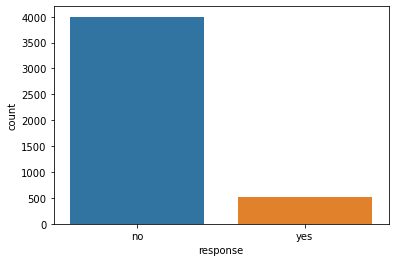

In [58]:
sns.countplot(imported_data.response)
#these are way unbalanced!

Text(0, 0.5, 'Proportion of Customers')

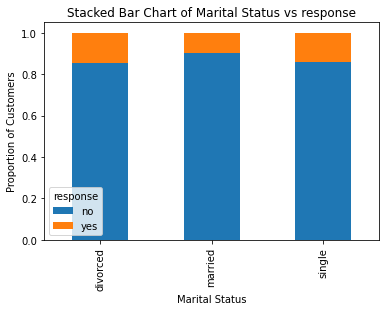

In [59]:
table=pd.crosstab(imported_data.marital,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs response')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')


Text(0, 0.5, 'Proportion of Customers')

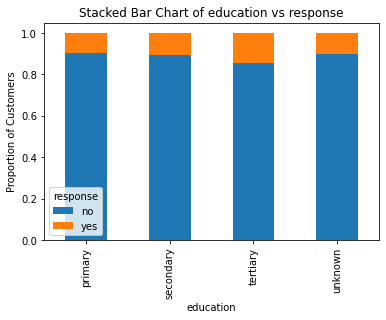

In [60]:
table=pd.crosstab(imported_data.education,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of education vs response')
plt.xlabel('education')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

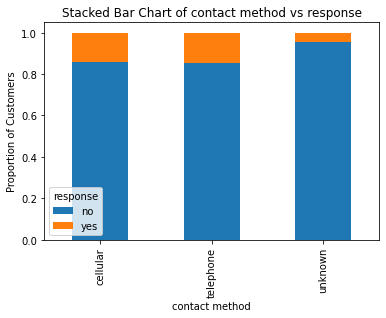

In [61]:
table=pd.crosstab(imported_data.contact,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of contact method vs response')
plt.xlabel('contact method')
plt.ylabel('Proportion of Customers')



Text(0, 0.5, 'Proportion of Customers')

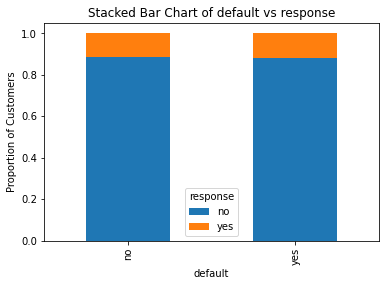

In [62]:
table=pd.crosstab(imported_data.default,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of default vs response')
plt.xlabel('default')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

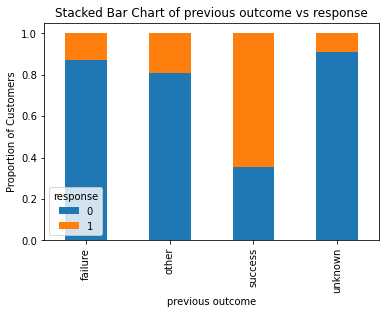

In [127]:
table=pd.crosstab(imported_data.poutcome,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of previous outcome vs response')
plt.xlabel('previous outcome')
plt.ylabel('Proportion of Customers')

In [63]:
#convert columns from y/n to 1/9
convert_to_binary = {'no' : 0, 'yes' : 1}

# define binary variable for having credit in default
default = imported_data['default'].map(convert_to_binary)
imported_data['default'] = default
# define binary variable for having a mortgage or housing loan
housing = imported_data['housing'].map(convert_to_binary)
imported_data['housing'] = housing
# define binary variable for having a personal loan
loan = imported_data['loan'].map(convert_to_binary)
imported_data['loan'] = loan
# define response variable to use in the model
response = imported_data['response'].map(convert_to_binary)
imported_data['response'] = response

display(imported_data.head())


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,0,4789,1,1,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,0,1350,1,0,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,0,1476,1,1,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,may,226,1,-1,0,unknown,0


In [126]:

df = imported_data.copy()
display(df.poutcome.value_counts())
display(df.contact.value_counts())
display(df.education.value_counts())
display(df.job.value_counts())
display(df.marital.value_counts())
display(df.poutcome.value_counts())

unknown    3705
failure     490
other       197
success     129
Name: poutcome, dtype: int64

cellular     2896
unknown      1324
telephone     301
Name: contact, dtype: int64

secondary    2306
tertiary     1350
primary       678
unknown       187
Name: education, dtype: int64

management       969
blue-collar      946
technician       768
admin.           478
services         417
retired          230
self-employed    183
entrepreneur     168
unemployed       128
housemaid        112
student           84
unknown           38
Name: job, dtype: int64

married     2797
single      1196
divorced     528
Name: marital, dtype: int64

unknown    3705
failure     490
other       197
success     129
Name: poutcome, dtype: int64

In [65]:
#poutcome != response
df[df.poutcome == 'success'].head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
49,61,admin.,married,unknown,0,4629,1,0,cellular,27,jan,181,1,92,1,success,1
70,37,management,married,tertiary,0,0,0,0,cellular,16,jul,268,2,182,3,success,1
98,36,blue-collar,divorced,secondary,0,2843,0,0,cellular,12,feb,473,1,182,1,success,0
110,21,student,single,secondary,0,2488,0,0,cellular,30,jun,258,6,169,3,success,1
156,55,admin.,married,secondary,0,602,0,0,cellular,1,jun,324,3,90,2,success,1


In [66]:
display(df.groupby(by='marital').agg(x= ('response', np.mean)))
display(df.groupby(by='contact').agg(x= ('response', np.mean)))
display(df.groupby(by='education').agg(x= ('response', np.mean)))
display(df.groupby(by='job').agg(x= ('response', np.mean)))

,x
marital,
divorced,0.145833
married,0.099035
single,0.139632


,x
contact,
cellular,0.143646
telephone,0.146179
unknown,0.046073


,x
education,
primary,0.094395
secondary,0.106245
tertiary,0.142963
unknown,0.101604


,x
job,
admin.,0.121339
blue-collar,0.072939
entrepreneur,0.089286
housemaid,0.125000
management,0.135191
retired,0.234783
self-employed,0.109290
services,0.091127
student,0.226190


In [129]:
#generates a binary response for married or not appends it to our dataframe
Married_Status = {'divorced' : 0, 'single' : 0, 'married' : 1}
married = df['marital'].map(Married_Status)
df['married'] = married

#generates a phone vs unknown binary response and appends to dataframe
Contact_Method = {'telephone' : 1, 'cellular' : 1, 'unknown' : 0}
phone = df['contact'].map(Contact_Method)
df['phone'] = phone

#generates a retried or not binary response column
df['retired'] = np.where(df['job'] == 'retired', 1 , 0)
#generates a student of not binary response column
df['student'] = np.where(df['job'] == 'student', 1 , 0)
#generates a p_outcome binary response column (previous marketing success)
df['p_outcome'] = np.where(df['poutcome'] == 'success', 1 , 0)

#drops columns from above contact, marital, poutcome now that we have a binary column for each
df.drop(['contact','marital', 'poutcome'], axis=1, inplace=True)

df.columns

Index(['age', 'job', 'education', 'default', 'balance', 'housing', 'loan',
       'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'response',
       'married', 'phone', 'retired', 'student', 'p_outcome'],
      dtype='object')

Text(0, 0.5, 'Proportion of Customers')

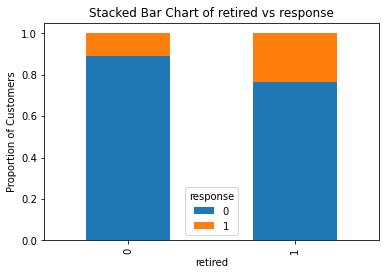

In [130]:

table=pd.crosstab(df.retired,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of retired vs response')
plt.xlabel('retired')
plt.ylabel('Proportion of Customers')





Text(0, 0.5, 'Proportion of Customers')

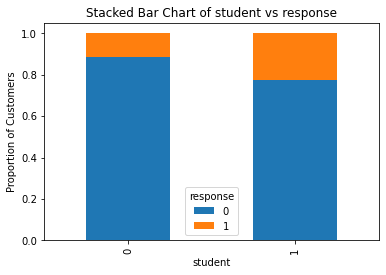

In [69]:
#there are a relatively small number of students <1% of the data. Likely should ignore this feature.
table=pd.crosstab(df.student,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of student vs response')
plt.xlabel('student')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

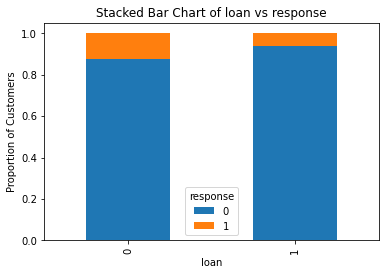

In [70]:
table=pd.crosstab(df.loan,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of loan vs response')
plt.xlabel('loan')
plt.ylabel('Proportion of Customers')

In [71]:
bank_df = df[['default', 'housing', 'loan', 'response']].copy()

In [72]:
#returns the proportion of positve responses
display(bank_df.groupby(by = default).agg(x= ('response', np.mean)))
display(bank_df.groupby(by = housing).agg(x= ('response', np.mean)))
display(bank_df.groupby(by = loan).agg(x= ('response', np.mean)))

,x
default,
0,0.115186
1,0.118421


,x
housing,
0,0.153415
1,0.085971


,x
loan,
0,0.124804
1,0.062229


# C. Regression Comparisons
## C1. Logistic Regression Classifier (default, housing, loan; to describe response; bank_df)

In [73]:
#split our train test out making sure we don't enrich our sets with one particular response
D_Train, D_Test = train_test_split(bank_df, test_size = 0.2, random_state = RANDOM_SEED, stratify = response)

#Train X and y
D_TrainY= D_Train['response'].copy()
D_TrainX= D_Train.drop('response', axis =1)

#Test X and y
D_TestY= D_Test['response'].copy()
D_TestX= D_Test.drop('response', axis =1)


## Evaluate if stratification

<AxesSubplot:xlabel='response', ylabel='count'>

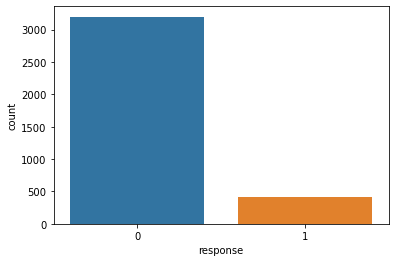

In [74]:
sns.countplot(D_Train.response)

<AxesSubplot:xlabel='response', ylabel='count'>

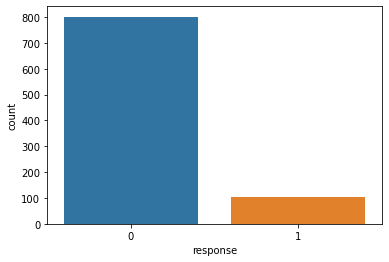

In [75]:
sns.countplot(D_Test.response)

In [76]:
D_TrainX.shape

(3616, 3)

### Pipeline construction
    1) I evaluated imputing the weights vs balanced weights, it looks like balanced might reverse the proportions
    2) AUC looks fairly good; 0.6; better than random chance!

In [77]:
#gets relative proportions of repsonses 
prop_1 = D_Train.response.sum()/D_Train.shape[0]
prop_0 = 1-prop_1

In [78]:
prop_1

0.115320796460177

In [79]:

Logreg_pipe = Pipeline([('regressor', LogisticRegression(class_weight = {0: prop_0, 1: prop_1}, random_state= RANDOM_SEED))])

#builds logistic regression pipeline
#Logreg_pipe = Pipeline([('regressor', LogisticRegression(class_weight = 'balanced', random_state= RANDOM_SEED))])
#fits logreg to out data
Logreg_pipe.fit(D_TrainX, D_TrainY)

#predict the labels from the train values
Logreg_train_pred = Logreg_pipe.predict_proba(D_TrainX)

Text(0.5, 1.0, 'ROC Curves for Logistic Regression')

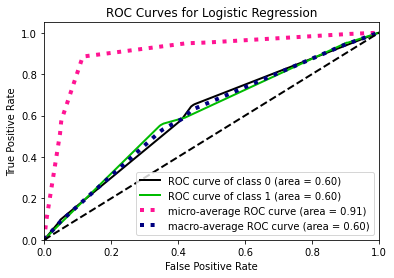

In [80]:

skplt.metrics.plot_roc_curve(D_TrainY, Logreg_train_pred )
plt.title('ROC Curves for Logistic Regression')

### Cross Validation

In [81]:
cv_results = cross_val_score(Logreg_pipe, D_TrainX, D_TrainY, cv=kfold, scoring= 'roc_auc')
print(cv_results)
np.mean(cv_results)

[0.59228422 0.62827004 0.60070412 0.6109736  0.59459459 0.60271021
 0.53228102 0.66340951]


0.6031534140246049

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

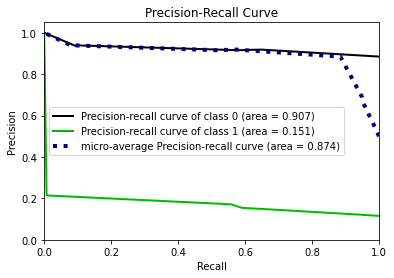

In [82]:
skplt.metrics.plot_precision_recall(D_TrainY, Logreg_train_pred)

## C2. Naive Bayes Classifier (default, housing, loan; to describe response; bank_df)

### Pipeline Construction

In [83]:
BernoulliNB_pipe = Pipeline([('regressor', BernoulliNB(alpha=0.8, class_prior=[prop_0, prop_1]))])
#fits logreg to out data
BernoulliNB_pipe.fit(D_TrainX, D_TrainY)

#predict the labels from the train values
BernoulliNB_train_pred = BernoulliNB_pipe.predict_proba(D_TrainX)

Text(0.5, 1.0, 'ROC Curves for Naive Bayes Classifier')

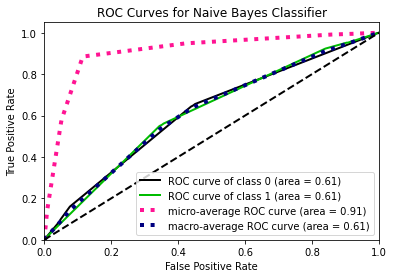

In [84]:
skplt.metrics.plot_roc_curve(D_TrainY, BernoulliNB_train_pred )
plt.title('ROC Curves for Naive Bayes Classifier')

### Cross Validation

In [85]:
cv_results = cross_val_score(BernoulliNB_pipe, D_TrainX, D_TrainY, cv=kfold, scoring= 'roc_auc')
print(cv_results)
np.mean(cv_results)

[0.61327372 0.62827004 0.60070412 0.6144802  0.61818182 0.60271021
 0.54176909 0.66340951]


0.6103498396132581

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

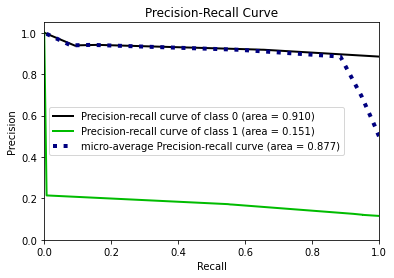

In [86]:
skplt.metrics.plot_precision_recall(D_TrainY, BernoulliNB_train_pred)

# D. More features! (housing, loan, retired, married, p_outcome)


In [163]:
Expanded_bank= df[['housing', 'loan', 'retired', 'married', 'p_outcome','response']].copy()

In [164]:
E_Train, E_Test = train_test_split(Expanded_bank, test_size = 0.2, random_state = RANDOM_SEED, stratify = response)

#Train X and y
E_TrainY= E_Train['response'].copy()
E_TrainX= E_Train.drop('response', axis =1)

#Test X and y
E_TestY= E_Test['response'].copy()
E_TestX= E_Test.drop('response', axis =1)



In [165]:
Expanded_bank.columns

Index(['housing', 'loan', 'retired', 'married', 'p_outcome', 'response'], dtype='object')

## D1. Logistic Regression

In [166]:
Logreg_pipe.fit(E_TrainX, E_TrainY)

#predict the labels from the train values
E_Logreg_train_pred = Logreg_pipe.predict_proba(E_TrainX)

Text(0.5, 1.0, 'ROC Curves for Logistic Regression with additional features')

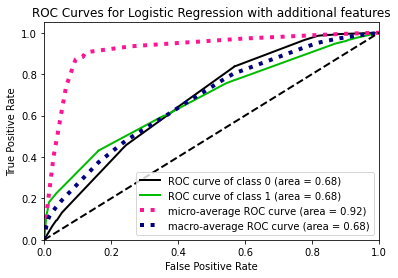

In [167]:
skplt.metrics.plot_roc_curve(E_TrainY, E_Logreg_train_pred )
plt.title('ROC Curves for Logistic Regression with additional features')

In [155]:
cv_results = cross_val_score(Logreg_pipe, E_TrainX, E_TrainY, cv=kfold, scoring= 'roc_auc')
print(cv_results)
np.mean(cv_results)

[0.72432534 0.69413724 0.66478412 0.64885004 0.6966967  0.6766068
 0.57926856 0.74100341]


0.6782090254194802

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

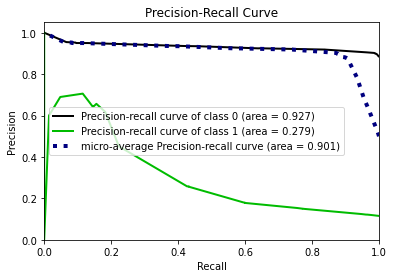

In [168]:
skplt.metrics.plot_precision_recall(E_TrainY, E_Logreg_train_pred)

## D2. Naive Bayes Classification

In [169]:
#fits logreg to out data
BernoulliNB_pipe.fit(E_TrainX, E_TrainY)

#predict the labels from the train values
EBernoulliNB_train_pred = BernoulliNB_pipe.predict_proba(E_TrainX)

Text(0.5, 1.0, 'ROC Curves for Naive Bayes Classifier with additional features')

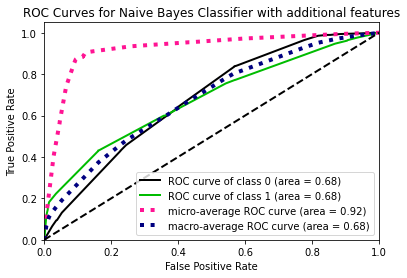

In [170]:
skplt.metrics.plot_roc_curve(E_TrainY, E_Logreg_train_pred )
plt.title('ROC Curves for Naive Bayes Classifier with additional features')

In [171]:
cv_results = cross_val_score(BernoulliNB_pipe, E_TrainX, E_TrainY, cv=kfold, scoring= 'roc_auc')
print(cv_results)
np.mean(cv_results)

[0.73155387 0.69440373 0.66219256 0.64663263 0.70619711 0.6756403
 0.58155432 0.7393223 ]


0.679687101986476

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

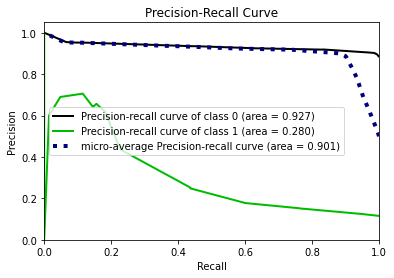

In [172]:
skplt.metrics.plot_precision_recall(E_TrainY, EBernoulliNB_train_pred)

# E. Only Phone Method of Contact

In [173]:
df.columns

Index(['age', 'job', 'education', 'default', 'balance', 'housing', 'loan',
       'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'response',
       'married', 'phone', 'retired', 'student', 'p_outcome'],
      dtype='object')

In [174]:
phone_df = df.copy()

In [175]:
phone_df = phone_df[phone_df['phone']==1]


<AxesSubplot:xlabel='response', ylabel='count'>

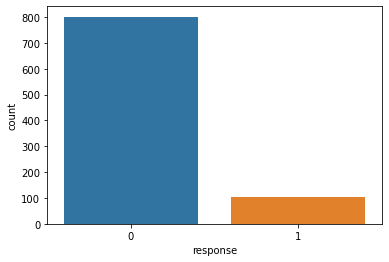

In [176]:
sns.countplot(D_Test.response)

Text(0, 0.5, 'Proportion of Customers')

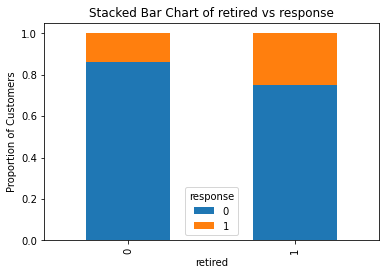

In [177]:
table=pd.crosstab(phone_df.retired,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of retired vs response')
plt.xlabel('retired')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

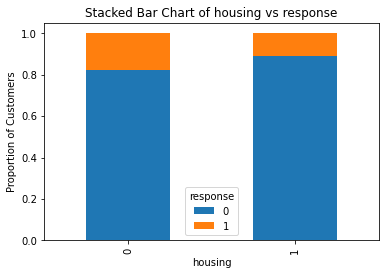

In [178]:
table=pd.crosstab(phone_df.housing,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of housing vs response')
plt.xlabel('housing')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

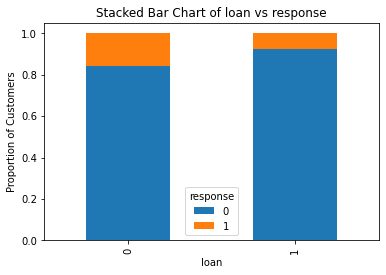

In [179]:
table=pd.crosstab(phone_df.loan,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of loan vs response')
plt.xlabel('loan')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

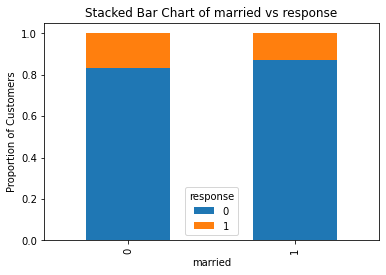

In [180]:
table=pd.crosstab(phone_df.married,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of married vs response')
plt.xlabel('married')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

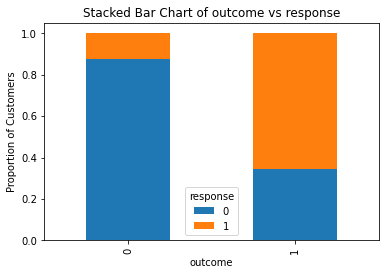

In [182]:
table=pd.crosstab(phone_df.p_outcome,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of outcome vs response')
plt.xlabel('outcome')
plt.ylabel('Proportion of Customers')